In [141]:
using LinearAlgebra
using ForwardDiff
using Plots
#using PlotlyJS

In [142]:
#parameters for the Earth Moon system 

μ = 1.215e-2 #gravitational parameter
μ1 = 1-μ
μ2 = μ

pose_m1 = [-μ, 0, 0]
pose_m2 = [1-μ, 0, 0]

L = 3.850e5 #in km - distance between centers of m1 and m2
V = 1.025 #in km/s - orbital velocity of m1
T = 2.361e6 #in seconds - orbital period of m1 and m2

h_s = 100 #time step for RK4 in seconds # original 10 seconds
h_v = 100 #original 10 seconds

time_scale = T/(2*pi)

h_rk4 = h_s/time_scale #non dimensionalized time
print(h_rk4)

h_var = h_v/time_scale

0.00026612390119354454

0.00026612390119354454

In [143]:
function potential_energy(X)
    
     x = X[1]
     y = X[2]
     z = X[3]
    
    
     r1 = sqrt((x+μ2)^2 + y^2 + z^2) 
     r2 = sqrt((x-μ1)^2 + y^2 + z^2)
     #assuming m3 is unit mass
    
     U = (-μ1/r1)-(μ2/r2)-0.5*(μ1*μ2)
    
     return U
end

potential_energy (generic function with 1 method)

In [144]:
function effective_potential(X)
    
     x = X[1]
     y = X[2]
     z = X[3]
    
    
     #r1 = sqrt((x+μ2)^2 + y^2) 
     #r2 = sqrt((x-μ1)^2 + y^2)
    
    r1 = sqrt((x+μ2)^2 + y^2+z^2) 
    r2 = sqrt((x-μ1)^2 + y^2+z^2)
     #assuming m3 is unit mass
    
    #U = (-μ1/r1)-(μ2/r2)-0.5*(x^2+y^2)
    #U = (-μ1/r1)-(μ2/r2)-0.5*(μ1*x^2+μ2*y^2)
    
    U = (-μ1/r1)-(μ2/r2)-0.5*(μ1*r1^2+μ2*r2^2) # working
    
     return U
end

effective_potential (generic function with 1 method)

In [145]:
#derivation for rotating
function three_body_prob_dynamics(x)
        
    q = x[1:3]
    v = x[4:6]
    a = zeros(3)
    
    U_q = (ForwardDiff.gradient(_x -> effective_potential(_x), q))
        
    a[1] = 2*v[2] - U_q[1]
    a[2] = -2*v[1] - U_q[2]
    a[3] = -U_q[3]
    
    ẋ = [v; a] #x dot is velocity and acceleration
    
    return ẋ
end


three_body_prob_dynamics (generic function with 1 method)

In [146]:
function jared_dynamics(rv) #Three body dynamics in Earth/Moon System
    x,y,z,vx,vy,vz = rv
    r₁³= ((x + μ)^2     + y^2 + z^2)^1.5 # distance to m1, LARGER MASS
    r₂³= ((x - 1 + μ)^2 + y^2 + z^2)^1.5 # distance to m2, smaller mass

    rvdot = zeros(6)
    rvdot[1:3] = [vx;vy;vz]
    rvdot[4] = -((1 - μ)*(x + μ)/r₁³) - (μ*(x - 1 + μ)/r₂³) + x + 2*vy
    rvdot[5] = -((1 - μ)*y      /r₁³) - (μ*y          /r₂³) + y - 2*vx
    rvdot[6] = -((1 - μ)*z      /r₁³) - (μ*z          /r₂³)
    
    return rvdot
end

jared_dynamics (generic function with 1 method)

In [147]:
function pkg_dynamics(rv) #Three body dynamics in Sun-Earth System

    
    #μ = 3.040423398444176e-6
    
    r₁³= ((rv[1] + μ)^2.0     + rv[2]^2.0 + rv[3]^2.0)^1.5; # distance to m1, LARGER MASS
    r₂³= ((rv[1] - 1 + μ)^2.0 + rv[2]^2.0 + rv[3]^2.0)^1.5; # distance to m2, smaller mass
    # r₁³= ((x + μ)^2     + y^2 + z^2)^1.5; # distance to m1, LARGER MASS
    # r₂³= ((x - 1 + μ)^2 + y^2 + z^2)^1.5; # distance to m2, smaller mass

#     rvdot = zeros(6)
    rvdot = zeros(eltype(rv),6)
    rvdot[1:3] = [rv[4];rv[5];rv[6]]
    rvdot[4] = -((1.0 - μ)*(rv[1] + μ)/r₁³) - (μ*(rv[1] - 1.0 + μ)/r₂³) + 2.0*rv[5] + rv[1];
    rvdot[5] = -((1.0 - μ)*rv[2]      /r₁³) - (μ*rv[2]          /r₂³) - 2.0*rv[4] + rv[2];
    rvdot[6] = -((1.0 - μ)*rv[3]      /r₁³) - (μ*rv[3]          /r₂³);
    return rvdot
end

pkg_dynamics (generic function with 1 method)

In [148]:
function RK4_satellite_potential_g(x)

    #f1 = three_body_prob_dynamics(x)
    #f2 = three_body_prob_dynamics(x+0.5*h_rk4*f1)
    #f3 = three_body_prob_dynamics(x+0.5*h_rk4*f2)
    #f4 = three_body_prob_dynamics(x+h_rk4*f3)
    
    f1 = pkg_dynamics(x)
    f2 = pkg_dynamics(x+0.5*h_rk4*f1)
    f3 = pkg_dynamics(x+0.5*h_rk4*f2)
    f4 = pkg_dynamics(x+h_rk4*f3)
    
    #forward in time
    xnext = x+(h_rk4/6.0)*(f1+2*f2+2*f3+f4)
    
    #backward in time
    #xnext = x-(h_rk4/6.0)*(f1+2*f2+2*f3+f4)
    
    return xnext
    
end

RK4_satellite_potential_g (generic function with 1 method)

In [149]:
function RK4_satellite_potential(x)

    f1 = three_body_prob_dynamics(x)
    f2 = three_body_prob_dynamics(x+0.5*h_rk4*f1)
    f3 = three_body_prob_dynamics(x+0.5*h_rk4*f2)
    f4 = three_body_prob_dynamics(x+h_rk4*f3)
    
    #forward in time
    xnext = x+(h_rk4/6.0)*(f1+2*f2+2*f3+f4)
    
    #backward in time
    #xnext = x-(h_rk4/6.0)*(f1+2*f2+2*f3+f4)
    
    return xnext
    
end

RK4_satellite_potential (generic function with 1 method)

In [150]:
ex_x0 = [1.0,2.0,3.0,4.0,5.0,6.0]

sol1 = pkg_dynamics(ex_x0)

sol2 = three_body_prob_dynamics(ex_x0)

display(sol1)

display(sol2)

6-element Vector{Float64}:
  4.0
  5.0
  6.0
 10.980959468059108
 -6.038136132380103
 -0.0572041985701543

6-element Vector{Float64}:
  4.0
  5.0
  6.0
 10.980959468059108
 -6.038136132380103
  2.942795801429846

In [151]:
one_min = 60/h_s #number of timesteps for 1 minute
min_day = 1440 #number of minutes this is a day
num_days = 12 # 6 days original
t_f=num_days*min_day 
N = Int(one_min*t_f) #time steps for duration

xk_g = zeros(6, N)
xk = zeros(6, N)

xk_off = zeros(6, N)

#initial condition for rk4 (working)
# xk[:,1] = [0.75, 0.01, 0.01, 0.085]
#xk[:,1] = [0.75, 0.01, 0, 10, 10.0, 10.0]
#L1 = [0.8369180073169304, 0, 0]

L1 = 0.8369180073169304


-0.21151685614932747
  8.69459011769262e-17
  0.0
 -2.27583928070302e-16
  1.770870182281887
  1.795253414404434

0.3556033994772462
  0.22411572113187364
  0.0
 -0.767633822798689
 -0.48379404700475315
  0.0

-0.35560339947724623
  0.22411572113187356
  0.0
 -0.767633822798689
  0.48379404700475315
  0.0

#stable L2
0.3556033994772462
  0.22411572113187364
  0.0
 -0.767633822798689
 -0.48379404700475315
  0.0


#works for 1e-1
stable_perturbation_L1 = 1e-1*[0.3556033994772462, 0.22411572113187364, 0, -0.767633822798689, -0.48379404700475315, 0]
unstable_perturbation_L1 =  0.05*[-0.35560339947724623, 0.22411572113187356,0, -0.767633822798689, 0.48379404700475315, 0]
#stable_perturbation1 = 1e-7*[-0.21151685614932747, 8.69459011769262e-17, 0.0,-2.27583928070302e-16, 1.770870182281887, 1.795253414404434]
#stable_eigen = [L1, 8.69459011769262e-17, -0.21151685614932747, -2.27583928070302e-16, 1.770870182281887,1.795253414404434]
stable_perturbation_L2 = 1e-1*[0.3556033994772462, 0.22411572113187364, 0,-0.767633822798689, -0.48379404700475315, 0]
#L1_km = 0.8369180073169304*L
#L2_km = 1.1556799130947355*L

#display(L1_km)
#display(L2_km)

#using the marginally stable eigen values

stable_perturbation_4 = 1*[-0.21151685614932747, 8.69459011769262e-17, 0.0,-2.27583928070302e-16, 1.770870182281887, 1.795253414404434]

stable_perturbation_4_fix = [-0.21151685614932747, 0.0, 0.0,0.0, 1.770870182281887, 0.0]

XL1 = [0.8369180073169304, 0, 0, 0, 0, 0]
XL2 = [1.1556799130947355, 0, 0, 0, 0, 0]

#stable_eigen1 = 1e-6*[0, 8.69459011769262e-17, -0.21151685614932747, 1.795253414404434, 1.770870182281887, -2.27583928070302e-16]
#initial_pose = [-0.21151685614932747, 8.69459011769262e-17, 0]
#initial_velocity = [-2.27583928070302e-16, 1.770870182281887, 1.795253414404434]
#xk[:,1] = [initial_pose; initial_velocity]
stable_eigen2 = [-0.30720121887787427, 2.155774426063215e-16, 0.0, -6.625394635729908e-16, 1.6666179843700804, 1.6571822780803005]

#stable_eigen2 = [-0.60720121887787427, 2.155774426063215e-16, 0.0, -6.625394635729908e-16, 1.6666179843700804, 1.6571822780803005]
#xk[:,1] = L1_full - stable_eigen1

#xk_g[:,1] = stable_perturbation_4
#xk[:,1] = stable_perturbation_4

xk[:,1] = XL1 + stable_perturbation_L1


#WORKS
#xk[:,1] = [0.8222791805122408,0.0,0.0,0.0,0.13799313179964737,0.0]

#xk_off[:,1] = [0.8225791805122408,0.0,0.0,0.0,0.13799313179964737,0.0]

#δ0 = norm(xk[1:3,1]- xk_off[1:3,1] )

print("this is delta0: ", δ0)

#testing
#xk[:,1] = [0.8229791805122408,0.0,0.0,0.0,0.13792313179964737,0.0]



#xk[:,1] = [0.8299379510640026, 0, 0, 0, 0.058438716015302275, 0.0]





#xk[:,1] = stable_perturbation_4_fix

#testing 
#xk[:,1] = [0.8157663217019977, 0, 0, 0, 0.17708701822818873, 0]


#from richardson jared
#xk[:,1] = [1.00842, 0.0, 9.12494e-6, 0.0, 0.00946368, 0.0]

#works
#xk[:,1] = XL1+stable_perturbation_L1

#xk[:,1] = XL2+stable_perturbation_L2

#xk[:,1] = XL1+unstable_perturbation_L1

#xk[:,1] = L1_new
#-0.21151685614932747
#  8.69459011769262e-17
#  0.0
# -2.27583928070302e-16
#  1.770870182281887
#  1.795253414404434
#xk[:,1] = [0.8369180073169304, 0, 0.01, 0.085]


#xk[:,1] = [1.1556799130947355, 0, 0.0, 0.0]
#L1 = (0.8369180073169304, 0)
#L2 = (1.1556799130947355, 0)

this is delta0: 0.00029999999999996696

In [152]:
N*100

1036800

In [153]:
δ0*L

115.49999999998728

In [154]:
N

10368

In [160]:
for k=1:N-1
    
    #xk_g[:,k+1] = RK4_satellite_potential_g(xk_g[:,k])
    xk[:,k+1] = RK4_satellite_potential(xk[:,k])
    #xk_off[:,k+1] = RK4_satellite_potential(xk_off[:,k])
    
end

In [161]:
xk[1,1]

0.8724783472646551

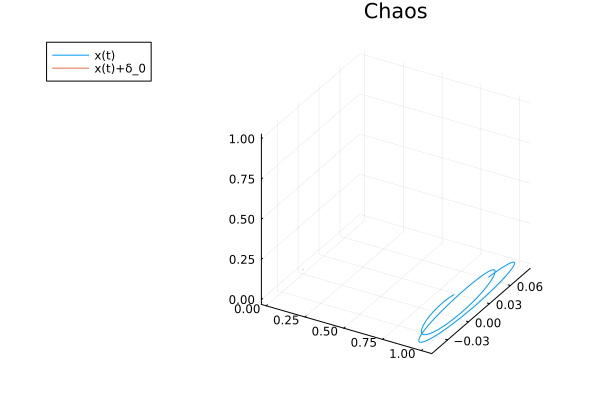

In [162]:
#orbit = PlotlyJS.scatter(x=xk[1,:], y=xk[2,:], z=xk[3,:], type="scatter3d", mode="lines", name="orbit 1&2");
#intial = PlotlyJS.scatter(x = [xk[1,1], xk[1,1]], y = [xk[2,1], xk[2,1]], z = [xk[3,1], xk[3,1]], type="scatter3d", mode="markers", marker_size=5);
#fig = PlotlyJS.plot([orbit]);

#fig

plot(xk[1,:], xk[2,:], xk[3,:], label = "x(t)", legend = :outertopleft)
plot!(xk_off[1,:], xk_off[2,:], xk_off[3,:], label = "x(t)+δ_0")
title!("Chaos")

In [163]:
δ = zeros(N)

N

for i=1:Int(N-2000)
        δ[i] = norm(xk[1:3, i] - xk_off[1:3, i])
end

In [164]:
xk

6×10368 Matrix{Float64}:
  0.872478    0.872458    0.872438   …   0.941983   0.941943    0.941904
  0.0224116   0.0223987   0.0223858      0.056953   0.0568803   0.0568074
  0.0         0.0         0.0            0.0        0.0         0.0
 -0.0767634  -0.0766628  -0.0765623     -0.149386  -0.149188   -0.14899
 -0.0483794  -0.0483857  -0.0483921     -0.273244  -0.273637   -0.274031
  0.0         0.0         0.0        …   0.0        0.0         0.0

In [165]:
logdelta = log.(δ)

10368-element Vector{Float64}:
  -0.1360876334144338
  -0.1361113960765922
  -0.13613512850754766
  -0.13615883073157725
  -0.13618250277292157
  -0.13620614465578484
  -0.1362297564043351
  -0.1362533380427035
  -0.13627688959498568
  -0.13630041108524013
  -0.13632390253749016
  -0.1363473639757219
  -0.136370795423886
   ⋮
 -Inf
 -Inf
 -Inf
 -Inf
 -Inf
 -Inf
 -Inf
 -Inf
 -Inf
 -Inf
 -Inf
 -Inf

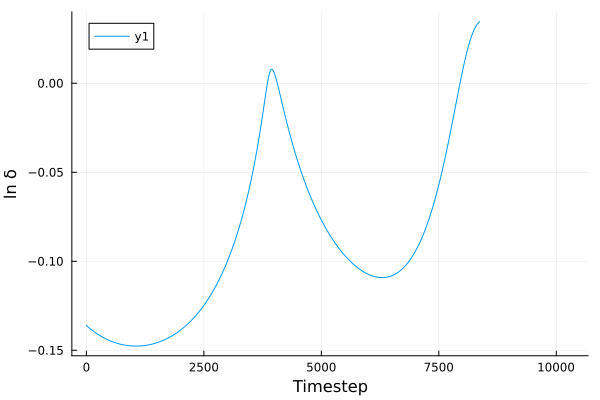

In [166]:
plot(log.(δ), xlabel = "Timestep", ylabel = "ln δ")

In [167]:
0.00026612390119354454*10368

2.7591726075746696

In [168]:
N/2

5184.0

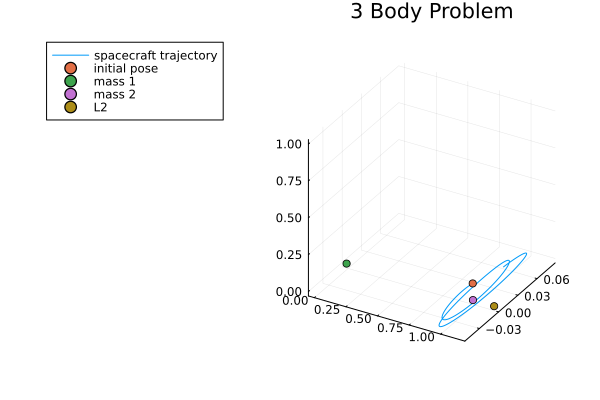

In [172]:
plot(xk[1,:], xk[2,:], xk[3,:], label = "spacecraft trajectory",  title="3 Body Problem", legend = :outertopleft)
#plot!(xk_g[1,:], xk_g[2,:], xk_g[3,:], label = "spacecraft trajectory",  title="3 Body Problem", legend = :outertopleft)

scatter!([xk[1,1]], [xk[2,1]], [xk[3,1]], label="initial pose")

scatter!([pose_m1[1]], [pose_m1[2]], [pose_m1[3]], label="mass 1")
scatter!([pose_m2[1]], [pose_m2[2]], [pose_m2[3]], label="mass 2")
scatter!([XL2[1]], [XL2[2]], [XL2[3]], label = "L2")

In [173]:
xk_transformed = zeros(6, N)

for k = 1:N
   xk_transformed[:,k] = xk[:,k] + XL1
    
end

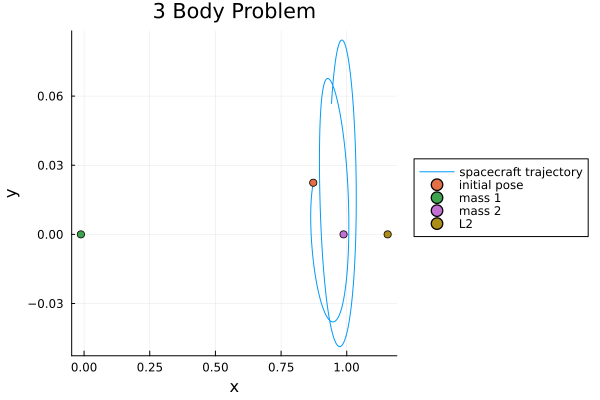

In [174]:
plot(xk[1,:], xk[2,:], label = "spacecraft trajectory",  title="3 Body Problem", legend = :outerright, xlabel = "x", ylabel="y")
scatter!([xk[1,1]], [xk[2,1]], label="initial pose")

scatter!([pose_m1[1]], [pose_m1[2]], label="mass 1")
scatter!([pose_m2[1]], [pose_m2[2]], label="mass 2")
scatter!([XL2[1]], [XL2[2]], label = "L2")

In [ ]:
plot(xk_transformed[1,:], xk_transformed[2,:], label = "spacecraft trajectory",  title="3 Body Problem", legend = :outerright, xlabel = "x", ylabel="y")
scatter!([xk_transformed[1,1]], [xk_transformed[2,1]], label="initial pose")

scatter!([pose_m1[1]], [pose_m1[2]], label="mass 1")
scatter!([pose_m2[1]], [pose_m2[2]], label="mass 2")
scatter!([XL1[1]], [XL1[2]], label = "L1")

scatter!([XL2[1]], [XL2[2]], label = "L2")

In [ ]:
plot(xk[2,:], xk[3,:], label = "spacecraft trajectory",  title="3 Body Problem")
scatter!([xk[2,1]], [xk[3,1]], label="initial pose")

scatter!([pose_m1[2]], [pose_m1[3]], label="mass 1")
scatter!([pose_m2[2]], [pose_m2[3]], label="mass 2")

In [ ]:
plot(xk[1,:], xk[3,:], label = "spacecraft trajectory",  title="3 Body Problem")
scatter!([xk[1,1]], [xk[3,1]], label="initial pose")

scatter!([pose_m1[1]], [pose_m1[3]], label="mass 1")
scatter!([pose_m2[1]], [pose_m2[3]], label="mass 2")

In [ ]:
#velcity norm of the spacecraft at each time step
v_all = sqrt.(xk[3,:].*xk[3,:] + xk[4,:].*xk[4,:])

In [ ]:
print(N)

In [ ]:
potential_E = zeros(N)

#find the potential energy at each time step
for i=1:N
    
    X = [xk[1,i], xk[2,i], xk[3,i]]
    
    potential_E[i] = potential_energy(X)
    
end

In [ ]:
#plotting the total energy in the system
total_energy = 0.5.*v_all.^2 + potential_E

In [ ]:
plot(1:N, total_energy, xlabel="Timestep", ylabel = "Energy", label= "RK4", title="Nondimensionalized Energy using RK4" )

In [ ]:
#Implement the variational Integrator

function Ld_pose(r1,r2)
    
    M = 1.0*Matrix(I, 3, 3)
    
    mid_height = (r1+r2)/2 
    
    rk_diff = (r2-r1)/h_var
    
    x = mid_height[1]
    y = mid_height[2]
    z = mid_height[3]
    
    x_dot = rk_diff[1]
    y_dot = rk_diff[2]
    z_dot = rk_diff[3]
    
    #Ld_pose = (h_var/2)*rk_diff'*M*rk_diff-h_var*potential_energy(mid_height)
    Ld_pose = (h_var/2)*(1)*((x_dot - y)^2 + (y_dot + x)^2 + z_dot^2) - h_var*potential_energy(mid_height)
        
    return Ld_pose
end

In [ ]:
r1 = xk[1:3,1]
r2 = xk[1:3,2]

In [ ]:
Ldpose = Ld_pose(r1,r2)

In [ ]:
function DLT1(q1,q2)
    
    r1 = q1[1:3]
    r2 = q2[1:3]    
    right_Legendre = ForwardDiff.gradient(dr1 -> Ld_pose(dr1,r2), r1)
    
    return right_Legendre
end


In [ ]:
function DLT2(q1,q2)
    r1 = q1[1:3]
    r2 = q2[1:3]
    left_Legendre = ForwardDiff.gradient(dr2 -> Ld_pose(r1,dr2), r2)

    return left_Legendre
end

In [ ]:
function DEL(q1,q2,q3)   
    
    DEL = DLT2(q1,q2) + DLT1(q2,q3)
    
    return DEL
end

In [ ]:
#simulate using a midpoint variational integrator

m3 = 1 #approximate m3 as unit mass


#initial conditions for variational integrator (working)
#r0 = [0.75, 0.01]
#v0 = [0.01, 0.085]
#xk[:,1] = [-0.21151685614932747, 8.69459011769262e-17, 0, -2.27583928070302e-16, 1.770870182281887, 1.795253414404434]
#initial conditions for variational integrator (testing)
#r0 = [0.8, 0.01]
stable_perturbation_L1 = 1e-3*[0.3556033994772462, 0.22411572113187364, 0, -0.767633822798689, -0.48379404700475315, 0]
stable = XL1+stable_perturbation_L1

display(stable)
#r0 = [L1-0.21151685614932747, 8.69459011769262e-17, 1e-12]
#r0 = [1.1556799130947355, 0] #L1
#v0 = [0.01, 0.085]
#v0 =  [-2.27583928070302e-16, 1.770870182281887, 1.795253414404434]
r0 = stable[1:3]
v0 = stable[4:6]

#r0[3] = 1e-8
#v0[3] = 1e-8


p0 = m3*v0

qhist = zeros(3,N)
phist = zeros(3,N)
#using RK4 sol (kinda working)
#qhist[:,1] .= xk[1:2,1]
#qhist[:,2] .= xk[1:2,2]

qhist[:,1] .= r0
#qhist[:,2] .= r0+(h_var.*v0)

#initialize momentumm
phist[:,1] .= p0

max_iterations = 20
tol = 1e-10

#for q1 and q2 initialize
#for k = 2:(N-1)

#for momentum initialize
for k = 1:(N-1)

#for k = 2:5
    
    qhist[:,k+1] .= qhist[:,k] #initial guess
    
    for i=1:max_iterations
        
        #e = DEL(qhist[:,k-1], qhist[:,k], qhist[:,k+1]) #DEL residual
        
        e = phist[:,k]+DLT1(qhist[:,k],qhist[:,k+1]) #residual for momentum as input
        
        if norm(e)<tol
            break
            
        end
    
        #jacobian = ForwardDiff.jacobian(dqhist-> DEL(qhist[:,k-1], qhist[:,k], dqhist), qhist[:,k+1])
               
        jacobian = ForwardDiff.jacobian(dqhist-> DLT1(qhist[:,k], dqhist), qhist[:,k+1])
        
        delta_q = jacobian\-e
            
        nextpose = qhist[:, k+1]+delta_q
        
        qhist[:,k+1] = nextpose
        
    end
    
    #udpate momentum (left discrete Legendre transform)
    phist[:,k+1] = DLT2(qhist[:,k],qhist[:,k+1])
    
    
end

In [ ]:
N

In [ ]:
phist[:,2]

In [ ]:
qhist[:,3]

In [ ]:
qhist[:,2]

In [ ]:
plot(qhist[1,:], qhist[2,:], qhist[3,:])
scatter!([qhist[1,1]], [qhist[2,1]], [qhist[3,1]])

scatter!([pose_m1[1]], [pose_m1[2]], [pose_m1[3]])
scatter!([pose_m2[1]], [pose_m2[2]], [pose_m2[3]])

xlabel!("X")
ylabel!("Y")
title!("Pose")

In [ ]:
plot(qhist[1,:], qhist[2,:], legend = :outertopleft)
#scatter!([qhist[1,1]], [qhist[2,1]])

#scatter!([pose_m1[1]], [pose_m1[2]])
#scatter!([pose_m2[1]], [pose_m2[2]])

#scatter!([pose_m1[1]], [pose_m1[2]], label = "mass1")
#scatter!([pose_m2[1]], [pose_m2[2]], label = "mass2")



# xlabel!("X")
# ylabel!("Y")
# title!("Pose")

In [ ]:
potential_E_var = zeros(N)

#find the potential energy at each time step
for i=1:N
    
    X = [qhist[1,i], qhist[2,i], qhist[3,i]]
    
    potential_E_var[i] = potential_energy(X)
    
end

In [ ]:
#momentum is the velocity in this case since we assume m3 is unit mass
size(phist)

#velcity norm of the spacecraft at each time step
v_all_var = sqrt.(phist[1,:].*phist[1,:] + phist[2,:].*phist[2,:]+ phist[3,:].*phist[3,:])

In [ ]:
v_all

In [ ]:
#plotting the total energy in the system
total_energy_var = 0.5.*v_all_var.^2 + potential_E_var

In [ ]:
plot(1:N, total_energy_var,  label= "Variational", title="Nondimensionalized Energy", linecolor="red")
#plot!(1:N, total_energy, label= "RK4", linecolor="green")
#xlabel!("Timestep")
#ylabel!("Energy")
#title!("Nonedimensionalized Energy")